In [1]:
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

from gradients.l2_data_fidelity import gradient_l2_data_fidelity
from problems import Problem
from proxes.l2_norm import prox_l2_norm
from solvers.myula import MYULA

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


# training minibatches = 10000


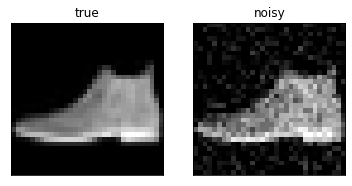

In [2]:
# Load data

img_size = 32 #resize the MNIST images to this dimension 

#dataloader
from torch.utils.data import DataLoader

transform_MYULA = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     ])

dataset = datasets.FashionMNIST(root='../data/FashionMNIST', train=False, transform=transform_MYULA, download=True)
train_loader = DataLoader(dataset, batch_size=1, shuffle=False)
print('# training minibatches = %d'%len(train_loader))

#add noise, denoise using a prox. operator
noise_sd = 0.10

for idx, (images, labels) in enumerate(train_loader):
  x_true = images #true images
  x_noisy = x_true + noise_sd*torch.randn(x_true.size())
  #see true, noisy, and denoised
  gt = x_true[0].detach().numpy().squeeze()
  data = x_noisy[0].detach().numpy().squeeze()

  plt.subplot(121)
  vmin, vmax = gt.min(), gt.max()
  plt.imshow(gt,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('true')

  plt.subplot(122)
  plt.imshow(data,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('noisy')

  plt.gcf().set_size_inches(6.0, 4.0)

  break

In [3]:
#unrolled gradient network (from notebook)
n_filters = 16
tau = 0.01*torch.ones(1)

class cnn_image_space(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=n_filters): #2 input channels, 1 for image, 1 for noisy data
        super(cnn_image_space, self).__init__()
        
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)
        
    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return dx
    
class unrolled_gradient_model(nn.Module):
    def __init__(self, niter=5, tau=tau): #niter=10 worked quite well
        super(unrolled_gradient_model, self).__init__()
        
        self.niter = niter
        self.tau = nn.Parameter(tau * torch.ones(self.niter))
        self.cnn_image_layers = nn.ModuleList([cnn_image_space() for i in range(self.niter)])
        
    def forward(self, y): #y = noisy data
        x = y
        for iteration in range(self.niter):
            x = x - self.tau[iteration] * self.cnn_image_layers[iteration](x, y) # x = x - step_size*dx
        return x

prox_dwt = unrolled_gradient_model()

In [4]:
# Setup problem parameters
delta = 0.1
lambd = 0.25 # must be same as in prox learn notebook

# Make sure gradient is in correct format
data_var = noise_sd**2
def gradient(x):
    return gradient_l2_data_fidelity(x,data)
#     return gradient_l2_data_fidelity(x,data,var=data_var)

# Load learned proximal map
model_path = os.path.join("..","models","unrolled_gradient_pretrained_nets","l1dwt_prox_model_epoch_09.pt")
prox_dwt.load_state_dict(torch.load(model_path))

def prox_g(lamb, x):
    z = torch.zeros(x_true.size())
    z[0,0,:,:] = torch.tensor(x)
    prox = prox_dwt(z)
    return prox.detach().numpy().squeeze()


prob = Problem(shape=data.shape)

myula_mc = MYULA(problem=prob,
               num_its=10000,
               burn_in=1000,
               thinning=20,
               x_init=data,
               gradient_f=gradient,
               prox_g=prox_g,
               delta=delta,
               lambd=lambd
               )


In [5]:
# Compute Markov Chain
chain = myula_mc.compute_chain()


Start burn-in steps
Start Markov chain steps
Iteration 0/10000
Iteration 20/10000
Iteration 40/10000
Iteration 60/10000
Iteration 80/10000
Iteration 100/10000
Iteration 120/10000
Iteration 140/10000
Iteration 160/10000
Iteration 180/10000
Iteration 200/10000
Iteration 220/10000
Iteration 240/10000
Iteration 260/10000
Iteration 280/10000
Iteration 300/10000
Iteration 320/10000
Iteration 340/10000
Iteration 360/10000
Iteration 380/10000
Iteration 400/10000
Iteration 420/10000
Iteration 440/10000
Iteration 460/10000
Iteration 480/10000
Iteration 500/10000
Iteration 520/10000
Iteration 540/10000
Iteration 560/10000
Iteration 580/10000
Iteration 600/10000
Iteration 620/10000
Iteration 640/10000
Iteration 660/10000
Iteration 680/10000
Iteration 700/10000
Iteration 720/10000
Iteration 740/10000
Iteration 760/10000
Iteration 780/10000
Iteration 800/10000
Iteration 820/10000
Iteration 840/10000
Iteration 860/10000
Iteration 880/10000
Iteration 900/10000
Iteration 920/10000
Iteration 940/10000
I

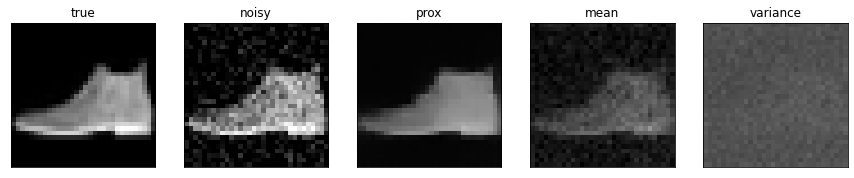

In [6]:
# Evaluate result

prox = prox_g(lambd, data)

mean = np.mean(chain,axis=0)
var = np.var(chain,axis=0)

plt.subplot(151)
plt.imshow(gt,cmap='gray',vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('true')

plt.subplot(152)
plt.imshow(data,cmap='gray',vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('noisy')

plt.subplot(153)
plt.imshow(prox,cmap='gray',vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('prox')

plt.subplot(154)
plt.imshow(mean,cmap='gray',vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('mean')

plt.subplot(155)
plt.imshow(var,cmap='gray',vmin=vmin, vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('variance')

plt.gcf().set_size_inches(15.0, 4.0)


In [7]:
# Evaluate whether the burn-in steps and the thinning are chosen properly
# TODO compute autocorrelation
# TODO compute costfunction